In [1]:
from collections import defaultdict
import json
import numpy as np
import os
import matplotlib.pyplot as plt
import re

In [2]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set_style('ticks')
import matplotlib.font_manager
for font in matplotlib.font_manager.findSystemFonts(
    '/Users/deepak/Library/Fonts/'):
    matplotlib.font_manager.fontManager.addfont(font)
font = {
    'font.family':'Roboto',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

In [3]:
RUN_DIR = "../benchmark_output/runs"

In [4]:
def get_per_instance_runtimes(per_instance_metrics):
    runtimes = []
    for values in per_instance_metrics:
        for metric in values["stats"]:
            if metric["name"]["name"] == "inference_runtime":
                assert metric["count"] == 1
                runtimes.append(metric["mean"])
    return runtimes

In [5]:
def get_data(api):
    run_dir = os.path.join(RUN_DIR, f"load_test/{api}_load_test") 
    data = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    metric_dirs = os.listdir(run_dir)
    tokenizer = "huggingface_gpt2" if api != "ai21" else "ai21_j1"
    pattern = (
        f"synthetic_efficiency:tokenizer={tokenizer},"
        f"num_prompt_tokens=(\d+),"
        f"num_output_tokens=(\d+),"
        f"random=(.*),"
        f"model=(.*)"
    )
    for metric_dir in os.listdir(run_dir):
        match = re.match(pattern, metric_dir)
        if match is None:
            continue
        num_input_tokens = int(match.group(1))
        num_output_tokens = int(match.group(2))
        random = match.group(3)
        num_threads = int(random.split("=")[-1])
        model = match.group(4).replace("_", "/")
        path = os.path.join(run_dir, metric_dir, "per_instance_stats.json")
        if os.path.exists(path):
            with open(path, "r") as f:
                per_instance_metrics = json.load(f)
                per_instance_runtimes = get_per_instance_runtimes(per_instance_metrics)
        else:
            per_instance_runtimes = [None]
        data[model][num_input_tokens][num_output_tokens][num_threads] = per_instance_runtimes
    return data

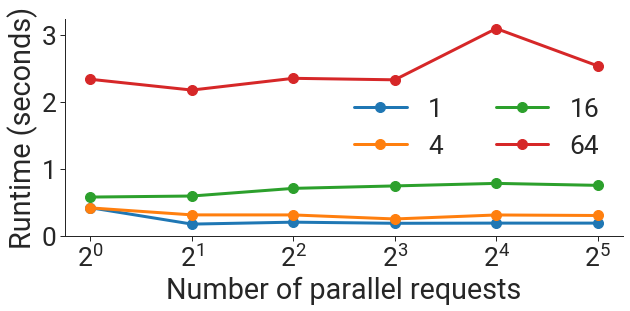

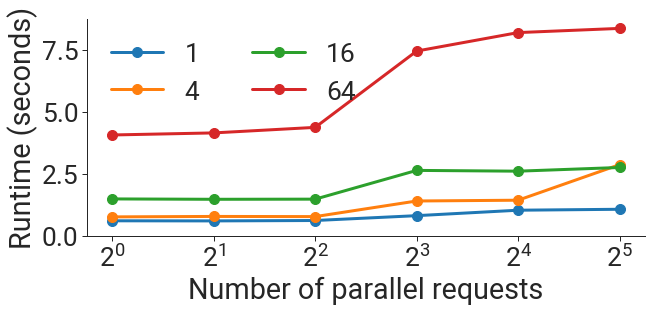

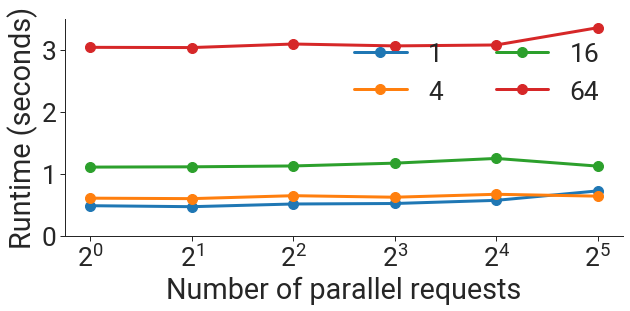

In [6]:
output_dir = "../figures/load_test"

for api in ["openai", "anthropic", "ai21"]:
    data = get_data(api)
    for model in data:
        for num_input_tokens in data[model]:
            plt.figure(figsize=(10, 4))
            for num_output_tokens in [1, 4, 16, 64]:
                x = sorted(data[model][num_input_tokens][num_output_tokens].keys())
                y = [np.min(data[model][num_input_tokens][num_output_tokens][num_threads]) for num_threads in x]
                plt.plot(x, y, label=f"{num_output_tokens}", marker="o")
            plt.legend(frameon=False, ncol=2)
            plt.xscale("log", base=2)
            plt.xlabel("Number of parallel requests")
            plt.ylabel("Runtime (seconds)")
            plt.ylim(0, None)
            
            sns.despine()
            
            if output_dir is not None:
                output_filename = os.path.join(output_dir, api + ".pdf")
                plt.savefig(output_filename, bbox_inches='tight')